#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [2]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [1]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen


In [2]:
wikipedia.set_lang("en")  #We make our research in english

#### definition of the function for the CORPUS SELECTION

In [3]:
def function_to_get_all_the_bloody_titles(key_words: str) -> list:
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=50&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    scraped_url2 = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit={page}&offset=0&profile=default&search={word}&ns0=1'.format(page = nbr_result, word = a)
    html_text2 = requests.get(scraped_url2).text
    soup2 = BeautifulSoup(html_text2, 'lxml')
    for interest in soup2.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles

In [4]:
def get_section_titles(page : str) -> list[str]:
    '''
    Returns the section titles

    :param page: Title of the page
    :return: The list of section titles
    '''
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [5]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys : str , number_of_results, key_for_section) -> list[str]:
    '''
    Select the corpus if the keywords are in the section or in the title

    :param word_keys : string 
    
    :return: a dictionnary containing the title of all the pages of the corpus
    '''
    corpus = []
    s_list = []
    search_list = function_to_get_all_the_bloody_titles(word_keys)[:number_of_results] #Select and put in a list number_of_results wikipedia articles related to word_keys
    a_list = []
    for i in search_list:
        try:
            wikipedia.summary(i, auto_suggest = False)
            a_list.append(i)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(i, auto_suggest = False)
                a_list.append(i)
            except wikipedia.exceptions.PageError as e:
                pass
    for j in a_list:
        if key_for_section in j.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(j)
        else:
            s_list.append(j) #Put the rest of the articles in a list
    for k in s_list:
        try :
            sec_tit = get_section_titles(k)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(k)
            except wikipedia.exceptions.PageError as e:
                pass
        for l in sec_tit:
            if key_for_section.replace(' ', '_').lower() in l.lower() and k not in corpus:
                corpus.append(k)
    return corpus

## TO LAUNCH THE CORPUS SELECTION

In [ ]:
%%time
search_list = corpus_selection("Effects of climate change", 13810, 'climate change')


C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [115]:
search_list=["Bird migration"]

In [18]:
len(search_list)#gives us the number of article in our corpus

707

In [112]:
set(search_list)#gives us the title of our corpus

{'Bird migration'}

#### definition of the function for the extraction of citation

In [7]:
# Some additional functions
def get_ids_from_ref(ref):
    d = dict(re.findall(r'(doi|pmc|pmid)\s?[=\|]\s?([^|\s}]*)', ref))
    ids = {k: v for k, v in d.items() if v}
    return ids

        
def get_citations(wikicode):
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>(.*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations:
        i+=1
        #print("beginning of c",i,c,"end of c")
        s.update(c.split('<br/>'))
        
    ds = pd.DataFrame(s, columns=['ref'])
    
    #print(list(ds['ref']))
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    ds["available"]=ds["ids"]== {}
    #print(ds["available"])
    dsbis= ds[(~ds['pmid'].isnull())|~(ds['doi'].isnull())|~(ds['pmc'].isnull())]
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]
    
    
    dg=ds.loc[ds["available"]==True,["ref"]]
    dg['idsIPCC']=dg['ref'].apply(get_IPCC_from_ref)
    dg['IPCC'] = dg['idsIPCC'].apply(lambda x: x.get('IPCC', None))
    dg["available"]= dg["idsIPCC"]=={}
    
    dorg=dg.loc[dg["available"]==True,["ref"]]
    #dg.groupby('User_ID')['Datetime'].apply(lambda g: len(g)>1)
    #dg = pd.DataFrame(s, columns=['ref'])
    dorg['ids'] = dorg['ref'].apply(get_org_from_ref)
    dorg['org'] = dorg['ids'].apply(lambda x: x.get('org', None))
    dorg["available"]= dorg["ids"]=={}
    
    dgov=dorg.loc[dorg["available"]==True,["ref"]]
    #dgov.drop(dgov[dgov['available'] == False].index, inplace=True)
        
    dgov['ids']=dgov['ref'].apply(get_gov_from_ref)
    dgov['gov'] = dgov['ids'].apply(lambda x: x.get('gov', None))
    dgov["available"]= dgov["ids"]=={}
    
    dguard=dgov.loc[dgov["available"]==True,["ref"]]
    dguard['ids']=dguard['ref'].apply(get_guardian_from_ref)
    dguard['guard'] = dguard['ids'].apply(lambda x: x.get('guard', None))
    dguard["available"]= dguard["ids"]=={}
    
    dcom=dguard.loc[dguard["available"]==True,["ref"]]
    dcom['ids']=dcom['ref'].apply(get_com_from_ref)
    dcom['com'] = dcom['ids'].apply(lambda x: x.get('com', None))
    dcom["available"]= dcom["ids"]=={}

    
    dipbes=dcom.loc[dcom["available"]==True,["ref"]]
    dipbes['ids']=dipbes['ref'].apply(get_ipbes_from_ref)
    dipbes['ipbes'] = dipbes['ids'].apply(lambda x: x.get('ipbes', None))
    dipbes["available"]= dipbes["ids"]=={}
    
    drest = dcom.loc[dcom["available"]==True,["ref"]]
    
    dgbisgov=dgov[(~dgov['gov'].isnull())]
    #dg = dg[(~dg['org'].duplicated()) | (dg['org'].isnull())]
    
    dgbisorg=dorg[(~dorg['org'].isnull())]
    #dg = dg[(~dg['gov'].duplicated()) | (dg['gov'].isnull())]
    
    dgbisIPCC=dg[(~dg['IPCC'].isnull())]
    #dg = dg[(~dg['IPCC'].duplicated()) | (dg['IPCC'].isnull())]
    
    dgbiscom=dcom[(~dcom['com'].isnull())]
    
    dbisguard = dguard[(~dguard['guard'].isnull())]
    dgbisipbes=dipbes[(~dipbes['ipbes'].isnull())]
    
    return {'Ref count': ds.shape[0], 'nb_journal_citations': ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],"citationjournal":list(list(dsbis["doi"])+list(dsbis["pmid"])+list(dsbis["pmc"])),"citations.org": dorg[(~dorg['org'].isnull())].shape[0],"citations.gov": dgov[(~dgov['gov'].isnull())].shape[0],"citationgovtext":list(dgbisgov['gov']),"citationorgtext":list(dgbisorg['org']),"citationsIPCC.ch": dg[(~dg['IPCC'].isnull())].shape[0],"citationIPCCtext":list(dgbisIPCC['IPCC']),"citationautre":list(drest["ref"]),"citationcomtext":list(dgbiscom['com']),"citations.com": dcom[(~dcom['com'].isnull())].shape[0],"citationipbestext":list(dgbisipbes['ipbes']),"citationsipbes": dipbes[(~dipbes['ipbes'].isnull())].shape[0],"citationguardian": dguard[(~dguard['guard'].isnull())].shape[0]}

In [63]:

def get_org_from_ref(ref):  
    citationorg=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)\.org)", ref, flags=re.IGNORECASE)))
    
    if 'web.archive.org' in citationorg:
        if len(citationorg)>1:
            citationorg.remove('web.archive.org')
        else:
            citationorg=[]
    if 'doi.org' in citationorg:
        if len(citationorg)!=1:
            citationorg.remove('doi.org')
        else:
            citationorg=[]
    if citationorg !=None and citationorg !=[]:
        
        #citationorg= [tuple(["org"]+citationorg)]
        g = {"org":citationorg}
        org = {k: v for k, v in g.items() if v}
        return org
    else:
        return{}

In [66]:
def get_gov_from_ref(ref):
        citationgov=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)\.gov)", ref, flags=re.IGNORECASE)))
        if citationgov !=None and citationgov !=[]:
            g= {"gov" : citationgov}          
            gov = {k: v for k, v in g.items() if v}
            return gov
        else:
            return{}
def get_com_from_ref(ref):
        citationgov=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)\.com)", ref, flags=re.IGNORECASE)))
        if citationgov !=None and citationgov !=[]:
            g= {"com" : citationgov}          
            com = {k: v for k, v in g.items() if v}
            return com
        else:
            return{}


In [67]:
def get_IPCC_from_ref(ref):
        citationIPCC=list(set(re.findall(r"(ipcc)", ref, flags=re.IGNORECASE)))
        if citationIPCC !=None and citationIPCC !=[]:
            g= {"IPCC" : citationIPCC}          
            IPCC = {k: v for k, v in g.items() if v}
            return IPCC
        else:
            return{}

def get_ipbes_from_ref(ref):
        citationIPCC=list(set(re.findall(r"(ipbes)", ref, flags=re.IGNORECASE)))
        if citationIPCC !=None and citationIPCC !=[]:
            g= {"ipbes" : citationIPCC}          
            ipbes = {k: v for k, v in g.items() if v}
            return ipbes
        else:
            return{}
def get_guardian_from_ref(ref):
        citationIPCC=list(set(re.findall(r"(guardian)", ref, flags=re.IGNORECASE)))
        if citationIPCC !=None and citationIPCC !=[]:
            g= {"guard" : citationIPCC}          
            guard = {k: v for k, v in g.items() if v}
            return guard
        else:
            return{}

#### creation du dataframe

In [135]:
def crea_dataframe(search_list,keyword : str):
    tableau =[] #creation of a list that will contain a dictionnary for each page with the information
    for i in range(len(search_list)):
        page =wikipedia.page(search_list[i], auto_suggest = False)
        page_title =page.title #give the clean name of the page
        page_url=page.url #give the url of the page
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, page_title)
        if keyword.lower() in page_title.lower():
            page_text=page.text
        else:
            page_text = str(re.findall(r'(?:==(?:\w|\ )*?(?:C|c)limate change(?:\w|\ )*?==\n)((?:.|\n)*?)(?:==(?:\w|\ )*==\n)', page.text))
        if page_text=="[]":
            page_text = str(re.findall(r'(?:===(?:\w|\ )*?(?:C|c)limate change(?:\w|\ )*?===\n)((?:.|\n)*?)(?:(?:===|==)(?:\w|\ )*(?:===|==)\n)', page.text))
            
        infopage ={'Name only' : page_title, 'page url' :page_url,'text':page_text}
        tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)
    return df


df=crea_dataframe(search_list,"climate change")
df

,Name only,page url,text
0,Bird migration,https://en.wikipedia.org/wiki/Bird_migration,['Large scale [[global warming|climatic change...


#### extract from text document the wiki code

In [51]:
# %load '2008.txt'
def text_import(year : int):
    
    filename =str(year) +".txt"
    dataframe_name = pd.read_csv(filename, sep = '\t')
    print(type(dataframe_name))
    return str(dataframe_name)


In [9]:
 #creation of a list that will contain a dictionnary for each page with the information
for i in range(2006,2022):
    page =wikipedia.page(search_list[0], auto_suggest = False)
    page_title =i #give the clean name of the page
    page_url= "https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change&oldid=298597212" #give the url of the page
    text=text_import(str(i))
    infopage ={'Name only' : page_title, 'page url' :page_url,'text':text}
    tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)

NameError: name 'search_list' is not defined

In [118]:
df["text"]

0    []
Name: text, dtype: object

## Get the citations

In [136]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))
#print("getting journal names")
#df["journaux"] = df['text'].progress_apply(lambda x: trijournaux(x))
print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])
print("getting the number of scientific citations")
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])

print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])
df["citationIPCCtext"]=df['citations'].progress_apply(lambda x: x["citationIPCCtext"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])


print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

print("getting the other citation")
df["citationautre"]=df['citations'].progress_apply(lambda x: x["citationautre"])

df["org count"]=df["citation org"]/df["Ref count"]
df["gov count"]=df["citation gov"]/df["Ref count"]
df["com count"]=df["citation com"]/df["Ref count"]
df["Sci count"]=df['nb_journal_citations']/df['Ref count']
df['IPCC count']=df['citation IPCC']/df['Ref count']
df['percentage of official sources']=(df['nb_journal_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

Getting citations


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.98it/s]


getting the number of references


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the number of scientific citations


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.27it/s]


getting the number of .org citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 995.80it/s]


getting the number of .gov citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the number of IPCC citation


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


getting the .com citations


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 993.44it/s]


getting the ipbes citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.69it/s]


getting the guardian citation


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 995.80it/s]


getting the other citation


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]

Done!


,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,citationcomtext,citationipbes,citationguardian,citationautre,org count,gov count,com count,Sci count,IPCC count,percentage of official sources
0,Bird migration,https://en.wikipedia.org/wiki/Bird_migration,['Large scale [[global warming|climatic change...,"{'Ref count': 5, 'nb_journal_citations': 4, 'c...",5,4,"[10.1111/conl.12386, 10.1098/rspb.2003.2394, 1...",1,[[www.panda.org]],0,...,[],0,0,[],0.2,0.0,0.0,0.8,0.0,1.0


In [137]:
df.loc[:,["Name only","Ref count","citation IPCC","percentage of official sources","IPCC count","citationipbes","citationguardian"]]


,Name only,Ref count,citation IPCC,percentage of official sources,IPCC count,citationipbes,citationguardian
0,Bird migration,5,0,1.0,0.0,0,0


In [16]:
def creadicorg(name_cit : str ,dicorg : dict):
    '''
    and the citation name_cit to the dictionnary dicorg
    
    param name_cit: the name of the citation in the form of a string
    param dicorg: a dictionnary containing the name and number of citation already found is updated thanks to this funciton
    return dicorg
    '''
    test=name_cit
    if "www." in name_cit:
        name_cit=name_cit.replace('www.','')
        if name_cit in dicorg:
            dicorg[name_cit]+=1
        else:
            dicorg[name_cit]=1
    if name_cit=='gov':
        print(test)
    return dicorg

In [17]:
def sortcitation(d):
    '''
    param d: a column of a dataframe containing the text of the citation
    
    return dico: a dictionnary containing the name of the site of interest and the numbers of time it is found in d. 
    return dforg : a dataframe containing the name of the site of interest and the numbers of time it's found in descending order. 
    '''
    dicorg={}
    for liste_cit in d:
        #if the list is empty there is no need to extract
        if liste_cit!= []:
            listcitationorg=list(liste_cit)
            
            #when there is more then a row in d liste_cit[0] is a list while when there is only one row the type is a string
            if type(liste_cit[0])==type("r"):
                
                dicorg=creadicorg(liste_cit[0],dicorg)
            else :
                for i in liste_cit:
                    name_cit=i[0]
                    dicorg=creadicorg(name_cit,dicorg)

    dico=dicorg
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','numbertimescited'])
    dforg.sort_values(by=['numbertimescited'], inplace=True, ascending=False)
    return dforg,dico
    

In [80]:
df.loc[0,["Name only"]]=2022
df.set_index("Name only",inplace=True)


In [44]:
del df['citation']

,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,citationgovtext,citation IPCC,citationIPCCtext,citation com,citationcomtext,citationipbes,citationguardian,citationautre,Sci count,IPCC count,percentage of official sources
Name only,,,,,,,,,,,,,,,,,,,,
2022,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'nb_journal_citations': 57,...",252,57,"[10.1126/science.aai9214, 10.3390/ijerph130404...",27,"[[www.carbonbrief.org], [research.wri.org], [w...",23,"[[climate.nasa.gov, nasa.gov], [science2017.gl...",95,"[[ipcc], [ipcc, www.ipcc], [ipcc, report.ipcc]...",23,"[[www.livescience.com], [www.ecowatch.com], [w...",2,10,[{{cite news |date=5 may 2020 |title=climate c...,0.226190,0.376984,0.809524
2006,https://en.wikipedia.org/w/index.php?title=Eff...,[[Image:Recent Sea Level Rise.png|right|thum...,"{'Ref count': 0, 'nb_journal_citations': 0, 'c...",0,0,[],0,[],0,[],0,[],0,[],0,0,[],NaN,NaN,NaN
2007,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{See|Global warmin...,"{'Ref count': 110, 'nb_journal_citations': 6, ...",110,6,"[10.1029/2006gl028905, 10.1175%2fjcli3800.1, 1...",20,"[[www.abi.org], [www.zmag.org], [www.sciencema...",5,"[[www.usgcrp.gov], [www2.metoffice.gov], [www....",9,"[[ipcc, www.ipcc], [ipcc], [ipcc], [www.ipcc],...",25,"[[www.airportbusiness.com], [www.newscientist....",0,8,"[{{cite journal|author = knutson, thomas r. an...",0.054545,0.081818,0.363636
2008,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{pp-semi-protected...,"{'Ref count': 165, 'nb_journal_citations': 34,...",165,34,"[10.1007/s00300-006-0142-5, 10.1061/(asce)1527...",28,"[[www.davidsuzuki.org], [www.abi.org], [www.sc...",11,"[[www.epa.gov], [www.nasa.gov], [www2.metoffic...",11,"[[www.ipcc], [ipcc], [www.ipcc], [ipcc], [ipcc...",30,"[[www.iht.com], [www.airportbusiness.com, airp...",0,11,[[http://iis-db.stanford.edu/pubs/20887/pnas_5...,0.206061,0.066667,0.509091
2009,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 195, 'nb_journal_citations': 53,...",195,53,"[10.1007/s00300-006-0142-5, 10.1146/annurev.ec...",34,"[[www.davidsuzuki.org], [www.abi.org], [www.un...",15,"[[www.epa.gov], [www.nasa.gov], [www2.metoffic...",10,"[[ipcc], [ipcc], [ipcc, dn14634-sea-level-rise...",29,"[[www.iht.com], [www.insurancejournal.com], [e...",0,8,"[''[[the independent]]'', april 27, 2005, ""cli...",0.271795,0.051282,0.574359
2010,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 68, 'nb_journal_citations': 9, '...",68,9,"[10.1038/nature04095, 10.1038/nature09098, 10....",0,[],2,"[[newscenter.lbl.gov], [www.noaanews.noaa.gov]]",50,"[[www.ipcc], [www.ipcc], [ipcc], [www.ipcc], [...",1,[[www.economist.com]],0,0,"[{{cite web |author=raven, j. a. ''et al.'' |y...",0.132353,0.735294,0.897059
2011,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 150, 'nb_journal_citations': 8, ...",150,8,"[10.1126/science.1065863, 10.1257/aer.98.2.1, ...",1,[[americasclimatechoices.org]],13,"[[downloads.globalchange.gov], [www.globalchan...",116,"[[ipcc, www.ipcc], [ipcc, www.ipcc], [ipcc, ww...",1,[[www.economist.com]],0,0,[{{cite book | pages=243-245 | chapter=7 sea l...,0.053333,0.773333,0.920000
2012,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{about|(primarily)...,"{'Ref count': 177, 'nb_journal_citations': 15,...",177,15,"[10.1038/nature09098, 10.1029/2008gl033510, 10...",3,"[[www.fao.org], [siteresources.worldbank.org],...",15,"[[earthobservatory.nasa.gov], [www.ncdc.noaa.g...",112,"[[ipcc, www.ipcc], [ipcc], [ipcc, www.ipcc], [...",4,"[[www.economist.com], [www.sciencedaily.com], ...",0,0,[{{cite book | year=2008 | title=understanding...,0.084746,0.632768,0.8192

In [37]:
dforg,dico=sortcitation(df.loc[:,"citationorgtext"])
dforg

,name of site,numbertimescited
7,npr.org,199
337,wbur.org,158
17,fao.org,136
11,un.org,114
37,webcitation.org,101
...,...,...
823,icij.org,1
820,mnforsustain.org,1
819,weathernotebook.org,1
818,annals.org,1


In [55]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"])
dfgov

KeyError: 'citationgovtext'

In [39]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"])
dcom

,name of site,numbertimescited
10,nytimes.com,1184
4,washingtonpost.com,699
38,politico.com,348
1,bbc.com,337
116,cnn.com,337
...,...,...
1032,davidrumsey.com,1
1030,eurohockey.com,1
1028,waste-management-world.com,1
1027,themanitoban.com,1


#### Plot of the evoltuion of the citations

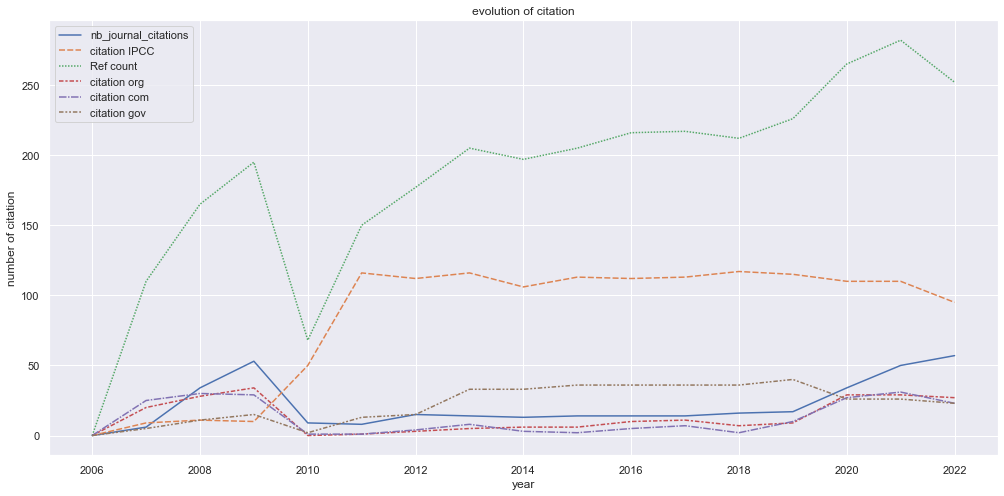

In [97]:
sns.lineplot(data=[df["nb_journal_citations"],df["citation IPCC"],df["Ref count"],df["citation org"],df["citation com"], df["citation gov"]]).set(title='evolution of citation',xlabel='year',ylabel='number of citation')
plt.savefig('evolution of citation.png')

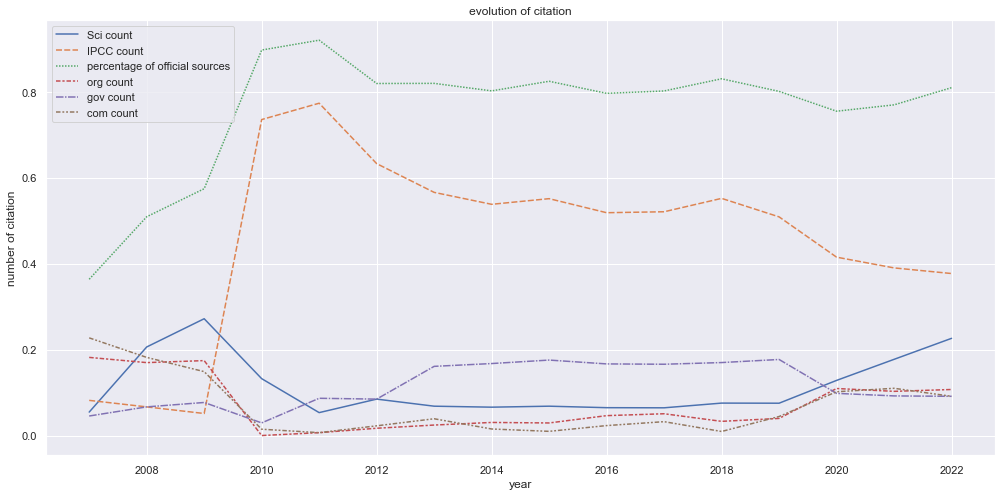

In [96]:
sns.set(rc = {'figure.figsize':(17,8)})
sns.lineplot(data=[df["Sci count"],df["IPCC count"],df['percentage of official sources'],df["org count"],df["gov count"],df["com count"]]).set(title='evolution of citation',xlabel='year',ylabel='number of citation')

plt.savefig('rate evolution of citation.png') 

#### dataframe containing the name of the evolution of the citation

In [56]:
def crea_df_evolution_citation(df, end_cit :str):  
    '''
    creation of a dataframe containing the number of a name of a citation finishing by name_cit (exemple org) for each year
    
    param df : the df containing the information the citation for an article and it's past
    param end_cit : the type of citation we want to extract it can be either .org, .com or .gov citations
    
    return dorg: a dataframe with axis the year and the name of the citation 
    '''
    columntext="citation"+end_cit+"text"
    columnnumber= "citation "+end_cit
    dorg=pd.DataFrame()

    for i in range(2007,2022):
        if int(df.loc[i,columnnumber])!=0:
            dforg,dicorg=sortcitation(df.loc[i,columntext])
            for j in dicorg.keys():
                dorg.loc[i,[j]]= dicorg[j]

    dorg=dorg.fillna(0)            

    dorg.loc["total",:]=dorg.sum(0)
    dorg["somme"]=dorg.sum(1)
    #new_df = dorg.loc[:, dorg.loc["total"]>1]
    #dorg = new_df.drop('total')
    return dorg

plotcit(df,"org")
plotcit(df,"gov")
plotcit(df,"com")
#plol_evol_cit(df.loc[i,["citationorg"]],df.loc[i,["citationorgtext"]])
#dorg.to_csv('climatechangehistoricdorg.csv')

,airportbusiness.com,newscientist.com,copenhagenconsensus.com,aaisonline.com,nature.com,munichre.com,washingtontimes.com,usatoday.com,salon.com,nytimes.com,...,nationalgeographic.com,marketwatch.com,britannica.com,bbc.com,smithsonianmag.com,theatlantic.com,sciencealert.com,sctimes.com,euronews.com,somme
2007,1.0,3.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
2008,1.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
2009,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2016,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [180]:
del df['citations']
del df['text']

In [40]:
df.to_csv('climatechange.csv')
dforg.to_csv('climatechangeorg.csv')
dfgov.to_csv('climatechangegov.csv')
dcom.to_csv('climatechangecom.csv')

In [40]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [41]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

print(urlmodifié)

['https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change&action=info', 'https://en.wikipedia.org/w/index.php?title=History_of_climate_change_science&action=info', 'https://en.wikipedia.org/w/index.php?title=Climate_change&action=info', 'https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change_on_plant_biodiversity&action=info', 'https://en.wikipedia.org/w/index.php?title=Climate_change_feedback&action=info', 'https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change_on_terrestrial_animals&action=info', 'https://en.wikipedia.org/w/index.php?title=Climate_change_and_fisheries&action=info', 'https://en.wikipedia.org/w/index.php?title=Attribution_of_recent_climate_change&action=info', 'https://en.wikipedia.org/w/index.php?title=Human_impact_on_marine_life&action=info', 'https://en.wikipedia.org/w/index.php?title=Bird_migration&action=info']


In [42]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    #soup = BeautifulSoup(source, "html.parser", from_encoding="utf-8")
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
    #recentpageviews += [df_pageinfo0.loc['Page views in the past 30 days']]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


In [ ]:
#df_pageinfo0
#df_pageinfo0.loc['Page ID']

In [43]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,Sci count,IPCC count,percentage of official sources,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'nb_journal_citations': 57,...",252,57,"[10.1007/s10584-014-1084-5, 10.1016/j.geoforum...",27,"[[www.ucsusa.org], [openknowledge.worldbank.or...",23,...,0.226190,0.376984,0.809524,2119174,Require autoconfirmed or confirmed access (no ...,186247,"15:09, 26 June 2005",Rd232 (talk | contribs),5537,19
1,History of climate change science,https://en.wikipedia.org/wiki/History_of_clima...,{{short description|Aspect of the history of s...,"{'Ref count': 91, 'nb_journal_citations': 28, ...",91,28,"[10.1007/bf00139058, 10.1175/1520-0469(1967)02...",20,"[[history.aip.org], [www.nobelprize.org], [www...",4,...,0.307692,0.010989,0.582418,23423379,Allow all users (no expiry set),78338,"22:48, 28 June 2009",Brian A Schmidt (talk | contribs),702,0
2,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 603, 'nb_journal_citations': 114...",603,114,"[10.1038/nclimate2979, 10.1002/2017rg000559, 1...",28,"[[www.carbonbrief.org], [www.un.org], [ourworl...",16,...,0.189055,0.255390,0.517413,5042951,Require administrator access (no expiry set),271809,"17:25, 30 October 2001",Zundark (talk | contribs),25731,45
3,Effects of climate change on plant biodiversity,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:Alpine flora logan pass.jpg|380px|thumb...,"{'Ref count': 60, 'nb_journal_citations': 41, ...",60,41,"[10.1007/s10113-015-0870-6, 10.1016/j.tplants....",3,"[[archive.org], [www.millenniumassessment.org]...",3,...,0.683333,0.000000,0.783333,19928041,Allow all users (no expiry set),43400,"01:54, 25 October 2008",Tom4216697 (talk | contribs),543,10
4,Climate change feedback,https://en.wikipedia.org/wiki/Climate_change_f...,{{short description|Feedback related to climat...,"{'Ref count': 103, 'nb_journal_citations': 45,...",103,45,"[10.1038/s41558-018-0344-1, 10.1029/gb002i003p...",10,"[[www.iucn.org], [climateprogress.org], [www.n...",11,...,0.436893,0.077670,0.718447,26198824,Allow all users (no expiry set),75482,"19:59, 14 February 2010",Shock Brigade Harvester Boris (talk | contribs),454,4


In [186]:
print("ref count",df["Ref count"])
print("unique",df['unique_references_xtools'])
print((int(df['unique_references_xtools'])-int(df["Ref count"])))

ref count 0    251
Name: Ref count, dtype: int64
unique 0    255
Name: unique_references_xtools, dtype: int64
4


In [44]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

In [45]:
dfbis=df

In [48]:
dfbis.groupby("Creator")
dfbis

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits,Formated DOB,Year_month,Year
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'nb_journal_citations': 57,...",252,57,"[10.1007/s10584-014-1084-5, 10.1016/j.geoforum...",27,"[[www.ucsusa.org], [openknowledge.worldbank.or...",23,...,2119174,Require autoconfirmed or confirmed access (no ...,186247,26 June 2005,Rd232,5537,19,2005-06-26,2005-06,2005
1,History of climate change science,https://en.wikipedia.org/wiki/History_of_clima...,{{short description|Aspect of the history of s...,"{'Ref count': 91, 'nb_journal_citations': 28, ...",91,28,"[10.1007/bf00139058, 10.1175/1520-0469(1967)02...",20,"[[history.aip.org], [www.nobelprize.org], [www...",4,...,23423379,Allow all users (no expiry set),78338,28 June 2009,Brian A Schmidt,702,0,2009-06-28,2009-06,2009
2,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 603, 'nb_journal_citations': 114...",603,114,"[10.1038/nclimate2979, 10.1002/2017rg000559, 1...",28,"[[www.carbonbrief.org], [www.un.org], [ourworl...",16,...,5042951,Require administrator access (no expiry set),271809,30 October 2001,Zundark,25731,45,2001-10-30,2001-10,2001
3,Effects of climate change on plant biodiversity,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:Alpine flora logan pass.jpg|380px|thumb...,"{'Ref count': 60, 'nb_journal_citations': 41, ...",60,41,"[10.1007/s10113-015-0870-6, 10.1016/j.tplants....",3,"[[archive.org], [www.millenniumassessment.org]...",3,...,19928041,Allow all users (no expiry set),43400,25 October 2008,Tom4216697,543,10,2008-10-25,2008-10,2008
4,Climate change feedback,https://en.wikipedia.org/wiki/Climate_change_f...,{{short description|Feedback related to climat...,"{'Ref count': 103, 'nb_journal_citations': 45,...",103,45,"[10.1038/s41558-018-0344-1, 10.1029/gb002i003p...",10,"[[www.iucn.org], [climateprogress.org], [www.n...",11,...,26198824,Allow all users (no expiry set),75482,14 February 2010,Shock Brigade Harvester Boris,454,4,2010-02-14,2010-02,2010
5,Effects of climate change on terrestrial animals,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Multiple issues|\n{{cleanup reorganize|date=...,"{'Ref count': 67, 'nb_journal_citations': 47, ...",67,47,[10.1175/1520-0477(2000)081<0413:aittie>2.3.co...,4,"[[www.pbs.org], [www.iucn.org], [cwf-fcf.org],...",1,...,31026536,Allow all users (no expiry set),83566,27 February 2011,Andreafaye171,313,0,2011-02-27,2011-02,2011
6,Climate change and fisheries,https://en.wikipedia.org/wiki/Climate_change_a...,[[Image:Bangladesh Fishing 2006.jpg|thumb|300p...,"{'Ref count': 58, 'nb_journal_citations': 22, ...",58,22,"[10.1017/9781009157964.006, 10.1111/j.1467-297...",19,"[[www.gefcoral.org], [ioc3.unesco.org], [ftp.f...",4,...,25279689,Allow all users (no expiry set),34567,2 December 2009,Kieran Kelleher,262,12,2009-12-02,2009-12,2009
7,Attribution of recent climate change,https://en.wikipedia.org/wiki/Attribution_of_r...,{{pp-semi-indef}}\n{{Use dmy dates|date=Decemb...,"{'Ref count': 112, 'nb_journal_citations': 21,...",112,21,"[10.1038/nature05718, 10.1093/ijpor/edr033, 10...",12,"[[www.virtualcentre.org], [americasclimatechoi...",23,...,3201,Require autoconfirmed or confirmed access (no ...,106684,16 January 2002,Ed Poor,1455,1,2002-01-16,2002-01,2002
8,Human impact on marine life,https://en.wikipedia.org/wiki/Human_impact_on_...,{{Short description|none}}\n{{Lead too short|d...,"{'Ref count': 143, 'nb_journal_citations': 60,...",143,60,"[10.1038/s41467-019-11394-4, 10.5194/bg-13-176...",20,"[[oceana.org], [royalsociety.org], [www.pewtru...",11,...,61622385,Allow all users (no expiry set),90561,28 August 2019,Jarble,351,0,2019-08-28,2019-08,2019
9,Bird migr

In [50]:
del df['citationorgtext']
del df['citationgovtext']
del df['text']
del df["citations"]

In [52]:
del df['citationIPCCtext']
del df["citationcomtext"]
df

,Name only,page url,Ref count,nb_journal_citations,journalcitation,citation org,citation gov,citation IPCC,citation com,citationipbes,...,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits,Formated DOB,Year_month,Year
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,252,57,"[10.1007/s40641-018-0093-2, 10.1073/pnas.18160...",27,23,95,23,2,...,2119174,Require autoconfirmed or confirmed access (no ...,186283,26 June 2005,Rd232,5536,18,2005-06-26,2005-06,2005
1,Climate change,https://en.wikipedia.org/wiki/Climate_change,603,114,"[10.1038/s41467-018-06885-9, 10.1126/science.1...",28,16,154,8,0,...,5042951,Require administrator access (no expiry set),271809,30 October 2001,Zundark,25731,45,2001-10-30,2001-10,2001
2,Effects of climate change on terrestrial animals,https://en.wikipedia.org/wiki/Effects_of_clima...,67,47,"[10.1111/j.1365-2699.2010.02384.x, 10.1371/jou...",4,1,1,8,0,...,31026536,Allow all users (no expiry set),83566,27 February 2011,Andreafaye171,313,0,2011-02-27,2011-02,2011
3,History of climate change science,https://en.wikipedia.org/wiki/History_of_clima...,91,28,"[10.1080/14786440709463737, 10.1063/pt.3.1295,...",20,4,1,10,0,...,23423379,Allow all users (no expiry set),78338,28 June 2009,Brian A Schmidt,702,0,2009-06-28,2009-06,2009
4,Climate change in Australia,https://en.wikipedia.org/wiki/Climate_change_i...,179,18,"[10.1038/d41586-020-00627-y, 10.1007/s10584-01...",16,34,3,29,0,...,14329297,Allow all users (no expiry set),135868,20 November 2007,Mac,928,2,2007-11-20,2007-11,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,North Indian Ocean tropical cyclone,https://en.wikipedia.org/wiki/North_Indian_Oce...,39,1,"[10.1002/jgrd.50396, None, None]",3,17,0,7,0,...,3028938,Allow all users (no expiry set),47363,29 October 2005,Hurricanehink,737,1,2005-10-29,2005-10,2005
703,Steller's eider,https://en.wikipedia.org/wiki/Steller%27s_eider,34,16,"[10.2307/1522072, 10.2307/1367319, 10.3996/naf...",8,7,0,0,0,...,356354,Allow all users (no expiry set),31496,4 November 2003,Jimfbleak,159,1,2003-11-04,2003-11,2003
704,Agulhas Leakage,https://en.wikipedia.org/wiki/Agulhas_Leakage,21,20,"[10.1029/1998jc900099, 10.1175/1520-0485(1982)...",0,0,0,0,0,...,70333148,Allow all users (no expiry set),16709,17 March 2022,Ezygarlowska,67,22,2022-03-17,2022-03,2022
705,Energy in Finland,https://en.wikipedia.org/wiki/Energy_in_Finland,66,0,[],16,0,1,0,0,...,19079887,Allow all users (no expiry set),42881,28 August 2008,Hartz,196,0,2008-08-28,2008-08,2008


In [53]:
df.to_csv('Theclimatechange.csv')

matplotlib.axes._subplots.AxesSubplot

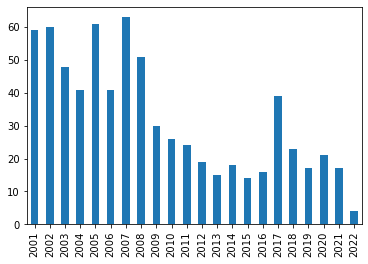

In [48]:
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")

type(plothist)

#### Next is xtools part, ignore it 

In [25]:
urlxtools_prose = ["https://xtools.wmflabs.org/api/page/prose/en.wikipedia.org/" + i for i in titleunderscore]
urlxtools_info = ["https://xtools.wmflabs.org/api/page/articleinfo/en.wikipedia.org/" + i for i in titleunderscore]

for i in titleunderscore:
    urlxtools_edits=["https://xtools.wmflabs.org/api/metrics/edits/per-page/en.wikipedia.org/" + i + "/all-editor-types/daily/20010101/20220101"]

In [26]:
import json
prose_dic=[]
unique_references_xtools=[]
key = "unique_references"
for i in tqdm(urlxtools_prose) :
    prose_str=requests.get(i).text
    prose_dic = json.loads(prose_str)
    
    unique_references_xtools.append(prose_dic[key])


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


In [22]:
df['unique_references_xtools']=unique_references_xtools

NameError: name 'unique_references_xtools' is not defined

In [ ]:
df.head()
df.to_csv('Corpus_CC_V3.csv')

In [ ]:
for i in urlxtools_edits:
    print(requests.get(i).text)


<!DOCTYPE html>
<html lang="en">
<head>
    <title>
        Error - XTools
    </title>

        <script type="text/javascript">
        xtBaseUrl = "/";

                i18nLang = "en";
        i18nPaths = {};
                    i18nPaths["en"] = "/i18n/en.json";
                    i18nPaths["en"] = "/i18n/en.json";
        
        i18nRTL = false;
    </script>

            <script type="text/javascript" src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/jquery/3.3.1/jquery.min.js"></script>
        <script type="text/javascript" src="/assets/app.753b88d7.js"></script>
        <script type="text/javascript" src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/twitter-bootstrap/3.3.7/js/bootstrap.min.js"></script>
        <script src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/select2/4.0.5/js/select2.full.min.js"></script>
                <link rel="stylesheet" type="text/css" media="screen" href="https://tools-static.wmflabs.org/cdnjs/ajax/libs/twitter-bootstrap/3.3.7

Trying to extract for weird formatted type but only one in our corpus => not necessary to do a program

In [27]:
for i in df["Ref count"]:
    if i==0:
        
            page = wikipedia.page(df.loc[i, "Name only"])
            print(df.loc[i, "Name only"])
            
            soup = BeautifulSoup(page.html(), 'html.parser')
            citations =soup.find_all('cite', {'class':"citation cs2"})
            for c in citations:
                test= get_ids_from_ref(str(c))

In [24]:
df

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,citationcomtext,citationipbes,citationguardian,citationautre,org count,gov count,com count,Sci count,IPCC count,percentage of official sources
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'nb_journal_citations': 57,...",252,57,"[10.1007/s10584-014-1084-5, 10.1016/j.geoforum...",27,"[[www.ucsusa.org], [openknowledge.worldbank.or...",23,...,"[[academic.oup.com], [www.nationalgeographic.c...",2,10,[{{cite web |title=motion for a resolution on ...,0.107143,0.091270,0.091270,0.226190,0.376984,0.809524
1,History of climate change science,https://en.wikipedia.org/wiki/History_of_clima...,{{short description|Aspect of the history of s...,"{'Ref count': 91, 'nb_journal_citations': 28, ...",91,28,"[10.1007/bf00139058, 10.1175/1520-0469(1967)02...",20,"[[history.aip.org], [www.nobelprize.org], [www...",4,...,"[[books.google.com], [books.google.com], [www....",0,2,"[john p. holdren: ""global thermal pollution"", ...",0.219780,0.043956,0.109890,0.307692,0.010989,0.582418
2,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 603, 'nb_journal_citations': 114...",603,114,"[10.1038/nclimate2979, 10.1002/2017rg000559, 1...",28,"[[www.carbonbrief.org], [www.un.org], [ourworl...",16,...,"[[books.google.com], [books.google.com], [book...",0,15,[{{cite web\n |title=the climate regime from t...,0.046434,0.026534,0.013267,0.189055,0.255390,0.517413
3,Effects of climate change on plant biodiversity,https://en.wikipedia.org/wiki/Effects_of_clima...,[[File:Alpine flora logan pass.jpg|380px|thumb...,"{'Ref count': 60, 'nb_journal_citations': 41, ...",60,41,"[10.1007/s10113-015-0870-6, 10.1016/j.tplants....",3,"[[archive.org], [www.millenniumassessment.org]...",3,...,[[justenergy.com]],0,0,"[{{cite conference |author=mackey, b. |title=c...",0.050000,0.050000,0.016667,0.683333,0.000000,0.783333
4,Climate change feedback,https://en.wikipedia.org/wiki/Climate_change_f...,{{short description|Feedback related to climat...,"{'Ref count': 103, 'nb_journal_citations': 45,...",103,45,"[10.1038/s41558-018-0344-1, 10.1029/gb002i003p...",10,"[[www.iucn.org], [climateprogress.org], [www.n...",11,...,"[[www.upi.com], [books.google.com], [www.washi...",0,6,[{{cite web |url=http://geotest.tamu.edu/userf...,0.097087,0.106796,0.077670,0.436893,0.077670,0.718447
5,Effects of climate change on terrestrial animals,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Multiple issues|\n{{cleanup reorganize|date=...,"{'Ref count': 67, 'nb_journal_citations': 47, ...",67,47,[10.1175/1520-0477(2000)081<0413:aittie>2.3.co...,4,"[[www.pbs.org], [www.iucn.org], [cwf-fcf.org],...",1,...,"[[softbacktravel.com], [theconversation.com], ...",0,0,"[mitchell, d., fuller, a., hetem, r. s., & mal...",0.059701,0.014925,0.119403,0.701493,0.014925,0.791045
6,Effects of climate change on oceans,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Short description|Effects of climate change ...,"{'Ref count': 121, 'nb_journal_citations': 64,...",121,64,"[10.1175/jcli-d-20-0366.1, 10.1017/s0030605307...",14,"[[www.sciencemag.org], [worldcat.org], [www.re...",3,...,"[[www.ecowatch.com], [www.sciencedaily.com], [...",0,1,"[usgs world energy assessment team, 2000. us g...",0.115702,0.024793,0.074380,0.528926,0.074380,0.743802
7,Attribution of recent climate change,https://en.wikipedia.org/wiki/Attribution_of_r...,{{pp-semi-indef}}\n{{Use dmy dates|date=Decemb...,"{'Ref count': 112, 'nb_journal_citations': 21,...",112,21,"[10.1038/nature05718, 10.1093/ijpor/edr033, 10...",12,"[[www.virtualcentre.org], [americasclimatechoi...",23,...,"[[www.ecowatch.com], [www.ecowatch.com], [spac...",0,0,"[{{harvnb|karl|others|2009}}, p. 20., {{harvnb...",0.107143,0.205357,0.080357,0.187500,0.232143,0.732143
8,Human impact